<a href="https://colab.research.google.com/github/arazm21/ML-homework_4/blob/main/expression_notebook_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# loading the data and organising it

In [1]:
! pip install kaggle
from google.colab import drive
drive.mount('/content/drive')
! mkdir ~/.kaggle
!cp /content/drive/MyDrive/ColabNotebooks/kaggle_API_credentials/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge
! unzip challenges-in-representation-learning-facial-expression-recognition-challenge

Mounted at /content/drive
 83% 236M/285M [00:00<00:00, 802MB/s] 
100% 285M/285M [00:00<00:00, 827MB/s]
Archive:  challenges-in-representation-learning-facial-expression-recognition-challenge.zip
  inflating: example_submission.csv  
  inflating: fer2013.tar.gz          
  inflating: icml_face_data.csv      
  inflating: test.csv                
  inflating: train.csv               


In [2]:
!pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 50.1 MB/s eta 0:00:00


In [3]:
import torch # Main PyTorch Library
from torch import nn # Used for creating the layers and loss function
from torch.optim import Adam # Adam Optimizer
import torchvision.transforms as transforms # Transform function used to modify and preprocess all the images
from torch.utils.data import Dataset, DataLoader # Dataset class and DataLoader for creating the objects
from sklearn.preprocessing import LabelEncoder # Label Encoder to encode the classes from strings to numbers
import matplotlib.pyplot as plt # Used for visualizing the images and plotting the training progress
from PIL import Image # Used to read the images from the directory
import pandas as pd # Used to read/create dataframes (csv) and process tabular data
import numpy as np # preprocessing and numerical/mathematical operations
import os # Used to read the images path from the directory

device = "cuda" if torch.cuda.is_available() else "cpu" # detect the GPU if any, if not use CPU, change cuda to mps if you have a mac
print("Device available: ", device)

Device available:  cuda


In [4]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import random
import numpy as np
from PIL import Image
from torchvision import transforms

# ─── 1) Augmentations for minority classes ────────────────────────────────────

aug_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.RandomHorizontalFlip(),
    # transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),  # finally convert to tensor in [0,1]
])

# ─── 2) Base “no‐transform” behavior ─────────────────────────────────────────

class ExpressionDatasetFromDF(Dataset):
    def __init__(self, dataframe):
        # Expect columns exactly ["emotion", "pixels", "Usage"]
        # Each “pixels” entry is a string of “230  19  …”
        self.images = dataframe[" pixels"].apply(
            lambda x: np.fromstring(x, sep=" ", dtype=np.uint8).reshape(48, 48)
        )
        # Stack into a (N, 1, 48, 48) float32 tensor in [0,1]
        self.images = torch.tensor(
            np.stack(self.images.values), dtype=torch.float32
        ).unsqueeze(1) / 255.0
        self.labels = torch.tensor(dataframe["emotion"].values, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]


# ─── 3) Oversampling / augmentation wrapper ──────────────────────────────────

class AugmentedExpressionDataset(Dataset):
    def __init__(self, base_dataset, targets, num_aug_per_sample=1):
        """
        base_dataset: an ExpressionDatasetFromDF (no transforms applied)
        targets: list of ints (same length as base_dataset)
        """
        self.base_dataset = base_dataset
        self.targets = targets
        self.class_counts = Counter(targets)
        self.max_count = max(self.class_counts.values())

        # Build a list of “base indices” to duplicate + augment
        self.augmented_indices = []
        for cls_label, count in self.class_counts.items():
            n_to_add = self.max_count - count
            if n_to_add <= 0:
                continue
            # pick with replacement from all indices whose target == cls_label
            indices_of_cls = [
                i for i, t in enumerate(targets) if t == cls_label
            ]
            sampled = random.choices(indices_of_cls, k=n_to_add * num_aug_per_sample)
            self.augmented_indices.extend(sampled)

        print(f"‣ Base dataset size: {len(self.base_dataset)}")
        print(f"‣ Augmenting {len(self.augmented_indices)} extra samples to balance classes.")
        print(f"‣ Resulting dataset size: {len(self.base_dataset) + len(self.augmented_indices)}")

    def __len__(self):
        return len(self.base_dataset) + len(self.augmented_indices)

    def __getitem__(self, idx):
        if idx < len(self.base_dataset):
            # no augmentation for the “original” sample
            img_tensor, label = self.base_dataset[idx]
            return img_tensor, label
        else:
            # for augmented ones: take the base index, convert back to PIL, augment, then ToTensor
            base_idx = self.augmented_indices[idx - len(self.base_dataset)]
            img_tensor, label = self.base_dataset[base_idx]
            # img_tensor is (1,48,48) float in [0,1]. Convert back to uint8 PIL:
            arr_uint8 = (img_tensor.squeeze().numpy() * 255).astype(np.uint8)
            pil_img = Image.fromarray(arr_uint8, mode="L")
            img_aug = aug_transform(pil_img)  # now a (1,48,48) FloatTensor in [0,1]
            return img_aug, label


# ─── 4) Revised get_data (no more “slice”) ───────────────────────────────────

def get_data(csv_file="icml_face_data.csv", train=True):
    """
    - Reads icml_face_data.csv (which has exactly ["emotion","pixels","Usage"]).
    - Splits by Usage == "Training" vs. "PublicTest".
    - For train: wraps in AugmentedExpressionDataset. For test/val: returns raw dataset.
    """
    full_df = pd.read_csv(csv_file)

    if train:
        df_part = full_df[full_df[" Usage"] == "Training"].reset_index(drop=True)
    else:
        df_part = full_df[full_df[" Usage"] == "PublicTest"].reset_index(drop=True)

    print(f"‣ Loaded '{'Training' if train else 'PublicTest'}' => {len(df_part)} samples before augmentation/slicing.")

    base_ds = ExpressionDatasetFromDF(df_part)

    if train:
        targets = df_part["emotion"].tolist()
        balanced_ds = AugmentedExpressionDataset(base_ds, targets)
        return balanced_ds
    else:
        return base_ds


def make_loader(dataset, batch_size):
    return DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=True,
        pin_memory=True,
        num_workers=1,
    )


In [16]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import random
import numpy as np
from PIL import Image
from torchvision import transforms

# ─── 1) Augmentations for minority classes ────────────────────────────────────

aug_transform = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),  # finally convert to tensor in [0,1]
])

# ─── 2) Base “no‐transform” behavior ─────────────────────────────────────────

class ExpressionDatasetFromDF(Dataset):
    def __init__(self, dataframe):
        # Expect columns exactly ["emotion", "pixels", "Usage"]
        # Each “pixels” entry is a string of “230  19  …”
        self.images = dataframe[" pixels"].apply(
            lambda x: np.fromstring(x, sep=" ", dtype=np.uint8).reshape(48, 48)
        )
        # Stack into a (N, 1, 48, 48) float32 tensor in [0,1]
        self.images = torch.tensor(
            np.stack(self.images.values), dtype=torch.float32
        ).unsqueeze(1) / 255.0
        self.labels = torch.tensor(dataframe["emotion"].values, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]


# ─── 3) Oversampling / augmentation wrapper ──────────────────────────────────

class AugmentedExpressionDataset(Dataset):
    def __init__(self, base_dataset, targets, num_aug_per_sample=1):
        """
        base_dataset: an ExpressionDatasetFromDF (no transforms applied)
        targets: list of ints (same length as base_dataset)
        """
        self.base_dataset = base_dataset
        self.targets = targets
        self.class_counts = Counter(targets)
        self.max_count = max(self.class_counts.values())

        # Build a list of “base indices” to duplicate + augment
        self.augmented_indices = []
        for cls_label, count in self.class_counts.items():
            n_to_add = self.max_count - count
            if n_to_add <= 0:
                continue
            # pick with replacement from all indices whose target == cls_label
            indices_of_cls = [
                i for i, t in enumerate(targets) if t == cls_label
            ]
            sampled = random.choices(indices_of_cls, k=n_to_add * num_aug_per_sample)
            self.augmented_indices.extend(sampled)

        print(f"‣ Base dataset size: {len(self.base_dataset)}")
        print(f"‣ Augmenting {len(self.augmented_indices)} extra samples to balance classes.")
        print(f"‣ Resulting dataset size: {len(self.base_dataset) + len(self.augmented_indices)}")

    def __len__(self):
        return len(self.base_dataset) + len(self.augmented_indices)

    def __getitem__(self, idx):
        if idx < len(self.base_dataset):
            # no augmentation for the “original” sample
            img_tensor, label = self.base_dataset[idx]
            return img_tensor, label
        else:
            # for augmented ones: take the base index, convert back to PIL, augment, then ToTensor
            base_idx = self.augmented_indices[idx - len(self.base_dataset)]
            img_tensor, label = self.base_dataset[base_idx]
            # img_tensor is (1,48,48) float in [0,1]. Convert back to uint8 PIL:
            arr_uint8 = (img_tensor.squeeze().numpy() * 255).astype(np.uint8)
            pil_img = Image.fromarray(arr_uint8, mode="L")
            img_aug = aug_transform(pil_img)  # now a (1,48,48) FloatTensor in [0,1]
            return img_aug, label


# ─── 4) Revised get_data (no more “slice”) ───────────────────────────────────

def get_data(csv_file="icml_face_data.csv", train=True, test=False):
    """
    - Reads icml_face_data.csv (which has exactly ["emotion","pixels","Usage"]).
    - Splits by Usage == "Training" vs. "PublicTest".
    - For train: wraps in AugmentedExpressionDataset. For test/val: returns raw dataset.
    """
    full_df = pd.read_csv(csv_file)

    if train:
        df_part = full_df[full_df[" Usage"] == "Training"].reset_index(drop=True)
    elif test==False:
        df_part = full_df[full_df[" Usage"] == "PublicTest"].reset_index(drop=True)
    else:
        df_part = full_df[full_df[" Usage"] == "PrivateTest"].reset_index(drop=True)
    print(f"‣ Loaded '{'Training' if train else 'PublicTest'}' => {len(df_part)} samples before augmentation/slicing.")

    base_ds = ExpressionDatasetFromDF(df_part)

    if train:
        targets = df_part["emotion"].tolist()
        balanced_ds = AugmentedExpressionDataset(base_ds, targets)
        return balanced_ds
    else:
        return base_ds


def make_loader(dataset, batch_size):
    return DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=True,
        pin_memory=True,
        num_workers=2,
    )


# ─── 5) Quick sanity check ───────────────────────────────────────────────────

if __name__ == "__main__":
    # 1) Inspect base “Training” size (should be ~28,709 for FER2013).
    train_ds = get_data(csv_file="icml_face_data.csv", train=True)
    print(f"Len of train_ds (after augmentation): {len(train_ds)}\n")

    # 2) Inspect base “PublicTest” size (should be ~3,589).
    val_ds = get_data(csv_file="icml_face_data.csv", train=False)
    print(f"Len of val_ds (no augmentation): {len(val_ds)}\n")

    # 3) Create DataLoader and confirm iteration count
    train_loader = make_loader(train_ds, batch_size=64)
    total_seen = sum(len(batch[0]) for batch in train_loader)
    print(f"Total images seen via train_loader: {total_seen}")


‣ Loaded 'Training' => 28709 samples before augmentation/slicing.
‣ Base dataset size: 28709
‣ Augmenting 21796 extra samples to balance classes.
‣ Resulting dataset size: 50505
Len of train_ds (after augmentation): 50505

‣ Loaded 'PublicTest' => 3589 samples before augmentation/slicing.
Len of val_ds (no augmentation): 3589

Total images seen via train_loader: 50505


## test that loading was ok

‣ Loaded 'PublicTest' => 3589 samples before augmentation/slicing.


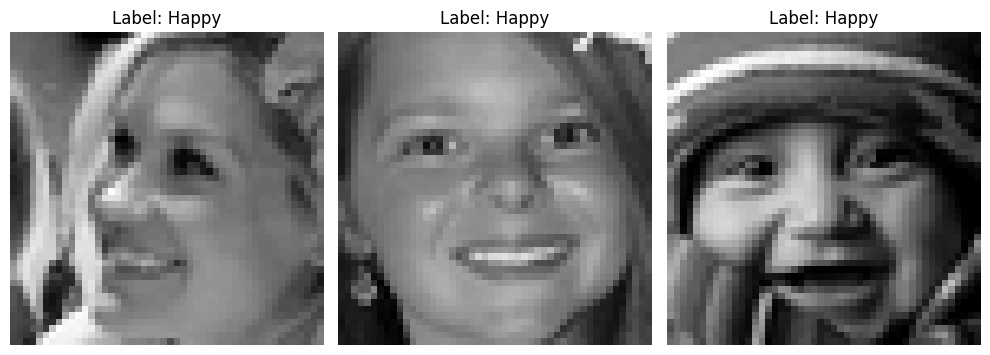

In [6]:
# Load and create loader
dataset = get_data(train=False)
loader = make_loader(dataset, batch_size=3)

# Get a batch
images, labels = next(iter(loader))

# Class names from FER2013
emotion_names = [
    "Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"
]

# Plot the first 3 images
plt.figure(figsize=(10, 4))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(images[i][0], cmap='gray')
    plt.title(f"Label: {emotion_names[labels[i].item()]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


# connecting WANDB

In [7]:
import os
import random

import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from tqdm.auto import tqdm

# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
torch.manual_seed(hash("by removing stochasticity") % 2**32 - 1)
torch.cuda.manual_seed_all(hash("so runs are repeatable") % 2**32 - 1)

# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [8]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: arazm21 (arazm21-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

# different attempted architectures

# geting everything ready

In [82]:
def make(config):
    # Make the data
    train_dataset = get_data(train=True)
    test_dataset = get_data(train=False)
    final_test_dataset = get_data(train=False, test=True)
    train_loader = make_loader(train_dataset, batch_size=config.batch_size)
    test_loader = make_loader(test_dataset, batch_size=config.batch_size)
    final_test_loader = make_loader(final_test_dataset, batch_size=config.batch_size)
    # Make the model
    model = k(block, [2, 2, 2,2], 1, 7).to(device)
    # model = timm.create_model('convit_tiny', pretrained=True, num_classes=7).to(device)
    # model = ViT(
    #     image_size=48,
    #     patch_size=6,
    #     num_classes=7,
    #     dim=128,          # embedding dimension
    #     depth=6,          # number of transformer layers
    #     heads=4,          # number of self-attention heads
    #     mlp_dim=256,      # hidden dim in the feedforward
    #     pool='cls',       # use cls token pooling
    #     channels=1,       # grayscale input
    #     dim_head=32,      # dimension per attention head
    #     dropout=0.1,      # transformer dropout
    #     emb_dropout=0.1   # dropout after patch+pos embedding
    # ).to(device)
    # model = ViT(
    #     image_size=48,
    #     patch_size=6,
    #     num_classes=7,
    #     dim=256,          # embedding dim
    #     depth=12,          # transformer depth (layers)
    #     heads=6,          # number of attention heads
    #     mlp_dim=512,      # feedforward hidden layer size
    #     pool='cls',       # cls token pooling
    #     channels=1,       # grayscale image
    #     dim_head=64,      # per-head dimension
    #     dropout=0.2,      # transformer dropout
    #     emb_dropout=0.1,  # embedding dropout
    #     patch_dropout=0.1 # optional patch dropout
    # ).to(device)
    # model = SimpleViT(
    #     num_classes = 7,
    #     image_size = 256,
    #     patch_size = 8,
    #     dim = 1024,
    #     depth = 12,
    #     heads = 8,
    #     mlp_dim = 2048,
    #     num_residual_streams = 8
    # ).to(device)

    # Make the loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)

    return model, train_loader, test_loader, criterion, optimizer, final_test_loader

In [69]:
def train_log(loss, example_ct, epoch):
    # Where the magic happens
    wandb.log({"epoch": epoch, "loss": loss}, step=example_ct)
    print(f"Loss after {str(example_ct).zfill(5)} examples: {loss:.3f}")

## early stop training

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

def validate(model, val_loader, criterion):
    model.eval()
    total = 0
    correct = 0
    val_loss = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= total
    val_acc = correct / total
    return val_loss, val_acc

def train(model, train_loader, val_loader, criterion, optimizer, config):
    wandb.watch(model, criterion, log="all", log_freq=10)

    early_stopper = EarlyStopping(patience=15, min_delta=0.001)

    example_ct = 0
    batch_ct = 0
    for epoch in tqdm(range(config.epochs)):
        model.train()
        running_correct = 0
        running_total = 0

        for _, (images, labels) in enumerate(train_loader):
            loss, batch_correct, batch_total = train_batch(images, labels, model, optimizer, criterion)
            example_ct += len(images)
            batch_ct += 1

            running_correct += batch_correct
            running_total += batch_total

            if ((batch_ct + 1) % 25) == 0:
                train_log(loss, example_ct, epoch)
                print(f"batch number: {batch_ct + 1}")

        train_acc = running_correct / running_total

        # ⏱️ Validate at the end of the epoch
        val_loss, val_acc = validate(model, val_loader, criterion)
        wandb.log({
            "epoch": epoch,
            "val_loss": val_loss,
            "val_accuracy": val_acc,
            "train_accuracy": train_acc
        })
        print(f"Epoch {epoch + 1}: val_loss = {val_loss:.4f}, val_acc = {val_acc:.4f}, train_acc = {train_acc:.4f}")

        # Check early stopping
        early_stopper(val_loss)
        if early_stopper.early_stop:
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break
def train_batch(images, labels, model, optimizer, criterion):
    images, labels = images.to(device), labels.to(device)

    outputs = model(images)
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    total = labels.size(0)

    return loss, correct, total

## normal training

In [22]:
import torch
from tqdm import tqdm
import wandb
from sklearn.metrics import confusion_matrix, f1_score
import matplotlib.pyplot as plt
import numpy as np


def train(model, train_loader, val_loader, criterion, optimizer, config, class_names= ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]):
    # wandb.init(
    #     project="",
    #     config={
    #         "epochs": config.epochs,
    #         "batch_size": train_loader.batch_size,
    #         "optimizer": optimizer.__class__.__name__,
    #         "lr": optimizer.param_groups[0]["lr"],
    #         "criterion": criterion.__class__.__name__,
    #     }
    # )
    # wandb.watch(model, log="all", log_freq=100)
    model.to(config.device)

    train_loss_plot, val_loss_plot = [], []
    train_acc_plot, val_acc_plot = [], []

    for epoch in range(config.epochs):
        # Training
        model.train()
        total_train_loss, train_correct, train_total = 0.0, 0, 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1} [Train]"):
            images, labels = images.to(config.device), labels.to(config.device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        train_loss = total_train_loss / train_total
        train_acc = train_correct / train_total

        # Validation
        val_loss, val_acc, all_targets, all_preds = validate(model, val_loader, criterion, config.device)

        # F1 and Confusion Matrix
        cm = confusion_matrix(all_targets, all_preds)
        f1_per_class = f1_score(all_targets, all_preds, average=None)

        log_data = {
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "train_acc": train_acc,
            "val_loss": val_loss,
            "val_acc": val_acc,
        }
        for i, name in enumerate(class_names):
            log_data[f"f1_{name}"] = f1_per_class[i]
        wandb.log(log_data)

        # Confusion matrix image
        fig, ax = plt.subplots(figsize=(6,6))
        im = ax.imshow(cm, cmap="Blues")
        fig.colorbar(im, ax=ax)
        ax.set_xticks(np.arange(len(class_names)))
        ax.set_yticks(np.arange(len(class_names)))
        ax.set_xticklabels(class_names, rotation=45, ha="right")
        ax.set_yticklabels(class_names)
        for i in range(len(class_names)):
            for j in range(len(class_names)):
                ax.text(j, i, cm[i, j], ha="center", va="center")
        ax.set_title(f"Confusion Matrix - Epoch {epoch+1}")
        ax.set_xlabel("Predicted")
        ax.set_ylabel("Actual")
        wandb.log({"confusion_matrix": wandb.Image(fig)})
        plt.close(fig)

        # Store for final plots
        train_loss_plot.append(train_loss)
        val_loss_plot.append(val_loss)
        train_acc_plot.append(train_acc)
        val_acc_plot.append(val_acc)

        print(f"Epoch {epoch+1}/{config.epochs}: "
              f"Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f} | "
              f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

    # Final loss/accuracy curves
    epochs_range = list(range(1, config.epochs + 1))

    fig1, ax1 = plt.subplots()
    ax1.plot(epochs_range, train_loss_plot, label="Train Loss")
    ax1.plot(epochs_range, val_loss_plot, label="Val Loss")
    ax1.set_title("Loss vs Epoch")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.legend()
    wandb.log({"loss_curve": wandb.Image(fig1)})
    plt.close(fig1)

    fig2, ax2 = plt.subplots()
    ax2.plot(epochs_range, train_acc_plot, label="Train Accuracy")
    ax2.plot(epochs_range, val_acc_plot, label="Val Accuracy")
    ax2.set_title("Accuracy vs Epoch")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy")
    ax2.legend()
    wandb.log({"accuracy_curve": wandb.Image(fig2)})
    plt.close(fig2)

    return model

def validate(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct, total = 0, 0
    all_preds, all_targets = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / total
    val_acc = correct / total
    return avg_val_loss, val_acc, all_targets, all_preds

import torch
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import wandb

def test(model, test_loader, device, class_names=None):
    model.eval()
    correct, total = 0, 0
    all_preds, all_targets = [], []
    misclassified_images = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())

            # Save misclassified images
            mis_mask = (predicted != labels)
            mis_imgs = images[mis_mask]
            mis_lbls = labels[mis_mask]
            mis_preds = predicted[mis_mask]
            for img, true_lbl, pred_lbl in zip(mis_imgs, mis_lbls, mis_preds):
                misclassified_images.append((img.cpu(), true_lbl.item(), pred_lbl.item()))

    acc = correct / total
    f1_macro = f1_score(all_targets, all_preds, average="macro")
    f1_per_class = f1_score(all_targets, all_preds, average=None)

    print(f"\nTest Accuracy: {acc:.2%}")
    print(f"F1 Macro: {f1_macro:.4f}")
    print("\nClassification Report:\n", classification_report(all_targets, all_preds, target_names=class_names))

    # Log numeric metrics
    log_data = {
        "test_accuracy": acc,
        "test_f1_macro": f1_macro,
    }
    if class_names:
        for i, name in enumerate(class_names):
            log_data[f"f1_{name}"] = f1_per_class[i]
    wandb.log(log_data)

    # Confusion matrix
    cm = confusion_matrix(all_targets, all_preds)
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        xticklabels=class_names if class_names else "auto",
        yticklabels=class_names if class_names else "auto",
        cmap="Blues"
    )
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_title("Confusion Matrix (Test)")
    # wandb.log({
    #     "confusion_matrix_final": wandb.Image(fig),
    #     "confusion_matrix_raw": wandb.Table(data=cm.tolist(), columns=class_names, rows=class_names),
    # })
    plt.close(fig)

    wandb.log({
    "confusion_matrix_final": wandb.Image(fig),
    "confusion_matrix_raw": wandb.plot.confusion_matrix(
        probs=None,
        y_true=all_targets,
        preds=all_preds,
        class_names=class_names if class_names else None
    )
})
    # Log a few misclassified images
    if class_names:
        wrong_table = wandb.Table(columns=["Image", "True Label", "Predicted Label"])
        for img, true_lbl, pred_lbl in misclassified_images[:25]:
            img_np = img.squeeze().numpy()  # assumes grayscale
            wrong_table.add_data(
                wandb.Image(img_np, caption=f"Pred: {class_names[pred_lbl]}, GT: {class_names[true_lbl]}"),
                class_names[true_lbl],
                class_names[pred_lbl]
            )
        wandb.log({"misclassified_samples": wrong_table})

    # Export ONNX
    dummy_input = torch.randn(1, *images.shape[1:]).to(device)
    torch.onnx.export(model, dummy_input, "model.onnx")
    wandb.save("model.onnx")

    # Optionally log model architecture as a string
    model_arch_str = str(model)
    wandb.log({"model_architecture": wandb.Html(f"<pre>{model_arch_str}</pre>")})



def Final_test(model, test_loader, device, class_names=None):
    model.eval()
    correct, total = 0, 0
    all_preds, all_targets = [], []
    misclassified_images = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())

            # Save misclassified images
            mis_mask = (predicted != labels)
            mis_imgs = images[mis_mask]
            mis_lbls = labels[mis_mask]
            mis_preds = predicted[mis_mask]
            for img, true_lbl, pred_lbl in zip(mis_imgs, mis_lbls, mis_preds):
                misclassified_images.append((img.cpu(), true_lbl.item(), pred_lbl.item()))

    acc = correct / total
    f1_macro = f1_score(all_targets, all_preds, average="macro")
    f1_per_class = f1_score(all_targets, all_preds, average=None)

    print(f"\nFinal_Test Accuracy: {acc:.2%}")
    print(f"Final_F1 Macro: {f1_macro:.4f}")
    print("\nFinal_Classification Report:\n", classification_report(all_targets, all_preds, target_names=class_names))

    # Log numeric metrics
    log_data = {
        "Final_test_accuracy": acc,
        "Final_test_f1_macro": f1_macro,
    }
    if class_names:
        for i, name in enumerate(class_names):
            log_data[f"f1_{name}"] = f1_per_class[i]
    wandb.log(log_data)

    # Confusion matrix
    cm = confusion_matrix(all_targets, all_preds)
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        xticklabels=class_names if class_names else "auto",
        yticklabels=class_names if class_names else "auto",
        cmap="Blues"
    )
    ax.set_xlabel("Final_Predicted")
    ax.set_ylabel("Final_Actual")
    ax.set_title("Final_Confusion Matrix (Test)")
    # wandb.log({
    #     "confusion_matrix_final": wandb.Image(fig),
    #     "confusion_matrix_raw": wandb.Table(data=cm.tolist(), columns=class_names, rows=class_names),
    # })
    plt.close(fig)

    wandb.log({
    "Final_confusion_matrix_final": wandb.Image(fig),
    "Final_confusion_matrix_raw": wandb.plot.confusion_matrix(
        probs=None,
        y_true=all_targets,
        preds=all_preds,
        class_names=class_names if class_names else None
    )
})
    # Log a few misclassified images
    if class_names:
        wrong_table = wandb.Table(columns=["Image", "True Label", "Predicted Label"])
        for img, true_lbl, pred_lbl in misclassified_images[:25]:
            img_np = img.squeeze().numpy()  # assumes grayscale
            wrong_table.add_data(
                wandb.Image(img_np, caption=f"Pred: {class_names[pred_lbl]}, GT: {class_names[true_lbl]}"),
                class_names[true_lbl],
                class_names[pred_lbl]
            )
        wandb.log({"Final_misclassified_samples": wrong_table})

    # Export ONNX
    dummy_input = torch.randn(1, *images.shape[1:]).to(device)
    # torch.onnx.export(model, dummy_input, "model.onnx")
    # wandb.save("model.onnx")

    # Optionally log model architecture as a string
    model_arch_str = str(model)
    wandb.log({"Final_model_architecture": wandb.Html(f"<pre>{model_arch_str}</pre>")})

## pipeline

In [70]:
def model_pipeline(hyperparameters):

    # tell wandb to get started
    with wandb.init(project="expression_dataset_final",
                    config=hyperparameters,
                    name = "resnet_og"):
      # access all HPs through wandb.config, so logging matches execution!
      config = wandb.config

      # make the model, data, and optimization problem
      model, train_loader, test_loader, criterion, optimizer, final_test_loader = make(config)
      print(model)

      # and use them to train the model
      # train(model, train_loader, criterion, optimizer, config)
      wandb.watch(model, log="all", log_freq=100)
      # # and test its final performance
      # test(model, test_loader)
      train(model, train_loader, test_loader, criterion, optimizer, config)
      test(model, test_loader, config.device)  # final test; you can use actual test set here if available
      Final_test(model, final_test_loader,config.device)

    wandb.finish()
    return model

In [83]:
config = dict(
    epochs=20,
    classes=7,
    #kernels=[32, 64, 128],
    batch_size=256,
    learning_rate=.3e-4,
    dataset="Facial Expression Recognition",
    architecture="resnet_og",
    device = device,
    weight_decay = 1e-4)

‣ Loaded 'Training' => 28709 samples before augmentation/slicing.
‣ Base dataset size: 28709
‣ Augmenting 21796 extra samples to balance classes.
‣ Resulting dataset size: 50505
‣ Loaded 'PublicTest' => 3589 samples before augmentation/slicing.
Label distribution in augmented training data:
Class 0: 7215 samples
Class 1: 7215 samples
Class 2: 7215 samples
Class 3: 7215 samples
Class 4: 7215 samples
Class 5: 7215 samples
Class 6: 7215 samples


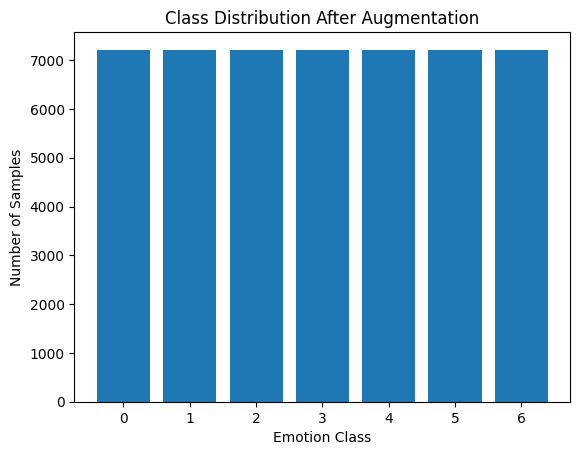

Total images seen via train_loader: 50505


In [42]:
total = 0
train_dataset = get_data(train=True)
test_dataset = get_data(train=False)
train_loader = make_loader(train_dataset, batch_size=config['batch_size'])
test_loader = make_loader(test_dataset, batch_size=config['batch_size'])
for batch in train_loader:
    images, labels = batch
    total += len(images)
# Count class occurrences
all_labels = []
for _, labels in train_loader:
    all_labels.extend(labels.tolist())

label_counts = Counter(all_labels)

# Print counts
print("Label distribution in augmented training data:")
for label, count in sorted(label_counts.items()):
    print(f"Class {label}: {count} samples")

# Optional: plot for visual confirmation
plt.bar(label_counts.keys(), label_counts.values(), tick_label=[str(i) for i in label_counts.keys()])
plt.xlabel('Emotion Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution After Augmentation')
plt.show()
print(f"Total images seen via train_loader: {total}")

# train!

In [ ]:
model = model_pipeline(config)

‣ Loaded 'Training' => 28709 samples before augmentation/slicing.
‣ Base dataset size: 28709
‣ Augmenting 21796 extra samples to balance classes.
‣ Resulting dataset size: 50505
‣ Loaded 'PublicTest' => 3589 samples before augmentation/slicing.
‣ Loaded 'PublicTest' => 3589 samples before augmentation/slicing.
ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): Identity()
  (layer1): Sequential(
    (0): block(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), 

Epoch 1 [Train]: 100%|██████████| 198/198 [04:01<00:00,  1.22s/it]


Epoch 1/20: Train Loss=1.7717, Train Acc=0.2816 | Val Loss=1.7700, Val Acc=0.2965


Epoch 2 [Train]:  41%|████▏     | 82/198 [01:40<02:21,  1.22s/it]

In [ ]:
print(device)

cuda:0
